*Pràctica 1 Aprenentatge Estadístic*

This notebook aims to implement, evaluate and optimize the hyperparameters of four different classification models based on decision trees.

Outline:

1. Data Cleaning
2. Funcions per a la evaluació
3. Decision Tree (CART)
4. Random Forest
5. XGBoost
6. Bayesian Tree
7. Models comparison

1. DATA CLEANING

In [1]:
import pandas as pd
import numpy as np

X = pd.read_csv("data.csv", delimiter=",")  
Y = pd.read_csv("flowering_time.csv", delimiter=",",header=None) 

print(X.head())
print(Y.head())
print(X.shape)
print(Y.shape)

   gtype.14  gtype.15  gtype.18  gtype.26  gtype.43  gtype.50  gtype.57  \
0         2         0         2         2         0         2         0   
1         0         1         0         2         0         0         0   
2         0         0         0         0         0         2         0   
3         0         2         0         0         0         0         0   
4         0         0         0         2         0         2         2   

   gtype.72  gtype.87  gtype.90  ...  gtype.100  gtype.104  gtype.116  \
0         0         2         0  ...          0          2          2   
1         0         0         0  ...          1          2          1   
2         0         2         2  ...          0          2          0   
3         2         1         2  ...          1          2          0   
4         2         2         0  ...          1          2          0   

   gtype.119  gtype.123  gtype.126  gtype.139  gtype.143    long     rec  
0          2          2          2 

In [2]:
Y = Y.squeeze()  
print("Nueva shape de Y:", Y.shape)  

Y_binaria = pd.Series([1 if x <= 40 else 0 for x in Y], name="Y_binaria") # Transform Y

print("Shape de Y_binaria:", Y_binaria.shape)  

Y_binaria.index = X.index 



df_final = pd.concat([X, Y_binaria], axis=1) # Merge datasets
print("Shape de df_final:", df_final.shape)

print(df_final)

Nueva shape de Y: (697,)
Shape de Y_binaria: (697,)
Shape de df_final: (697, 22)
     gtype.14  gtype.15  gtype.18  gtype.26  gtype.43  gtype.50  gtype.57  \
0           2         0         2         2         0         2         0   
1           0         1         0         2         0         0         0   
2           0         0         0         0         0         2         0   
3           0         2         0         0         0         0         0   
4           0         0         0         2         0         2         2   
..        ...       ...       ...       ...       ...       ...       ...   
692         2         2         0         0         0         2         2   
693         0         0         0         0         0         0         2   
694         0         0         2         2         0         2         0   
695         2         2         0         2         0         0         0   
696         0         0         0         0         0         0         

In [3]:
from sklearn.model_selection import train_test_split

df_muestra = df_final.sample(n=600, random_state=12345)  # Select 600 random rows

X = df_muestra.iloc[:, :-1] 
Y = df_muestra.iloc[:, -1]  

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3, random_state=12345) # Split data

print(X_train.shape)  
print(X_test.shape)   
print(Y_train.shape)  
print(Y_test.shape)  

print(Y_train.head)

(400, 21)
(200, 21)
(400,)
(200,)
<bound method NDFrame.head of 4      0
205    1
257    1
159    1
506    1
      ..
421    0
414    0
120    1
42     1
149    1
Name: Y_binaria, Length: 400, dtype: int64>


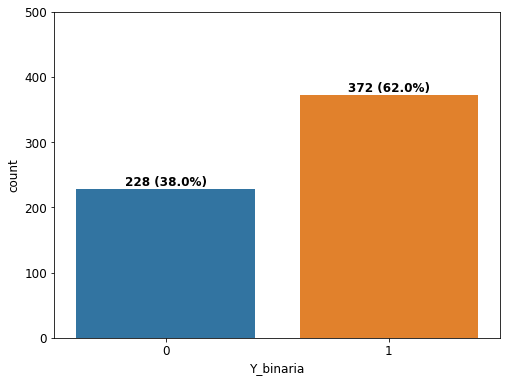

In [4]:
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.rc('font', size=12)
sns.countplot(data=df_muestra, x=df_muestra.iloc[:,-1])

# Obtener el número total de observaciones
total = df_muestra.shape[0]

for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2.,
            height + 0.9,
            '{:1.0f} ({:.1f}%)'.format(height, (height / total) * 100),
            ha="center", va="bottom",fontweight='bold')  # Ajusta la posición vertical del texto hacia abajo

plt.ylim(0,500);

In [5]:
df_muestra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 127 to 393
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gtype.14   600 non-null    int64  
 1   gtype.15   600 non-null    int64  
 2   gtype.18   600 non-null    int64  
 3   gtype.26   600 non-null    int64  
 4   gtype.43   600 non-null    int64  
 5   gtype.50   600 non-null    int64  
 6   gtype.57   600 non-null    int64  
 7   gtype.72   600 non-null    int64  
 8   gtype.87   600 non-null    int64  
 9   gtype.90   600 non-null    int64  
 10  gtype.92   600 non-null    int64  
 11  gtype.100  600 non-null    int64  
 12  gtype.104  600 non-null    int64  
 13  gtype.116  600 non-null    int64  
 14  gtype.119  600 non-null    int64  
 15  gtype.123  600 non-null    int64  
 16  gtype.126  600 non-null    int64  
 17  gtype.139  600 non-null    int64  
 18  gtype.143  600 non-null    int64  
 19  long       600 non-null    float64
 20  rec     

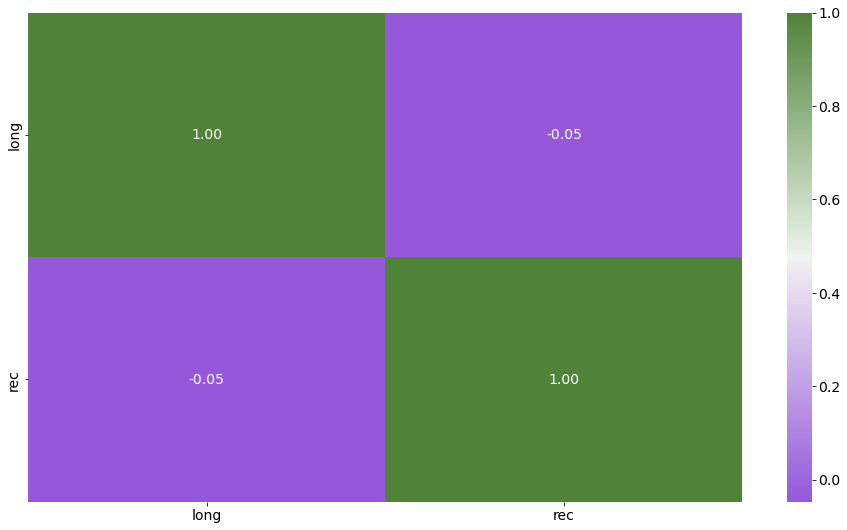

In [46]:
from scipy.stats import pearsonr

correlation_matrix =pd.DataFrame(index=["long", "rec"],
                                  columns=["long", "rec"]) # correlation between variables
for col1 in ["long", "rec"]:
    for col2 in ["long", "rec"]:
        correlation_matrix.loc[col1, col2] = pearsonr(df_muestra[col1], df_muestra[col2])[0]
        correlation_matrix.loc[col2, col1] = correlation_matrix.loc[col1, col2]

np.fill_diagonal(correlation_matrix.values, 1.00)
plt.figure(figsize=(16, 9))

plt.rc('font',size=14)
cmap = sns.diverging_palette( 1000, 120, as_cmap=True)
sns.heatmap(correlation_matrix.astype(float) , annot=True, fmt='.2f',cmap=cmap);#annot=True, fmt='.1%',  linewidths=.05,

2. FUNCTIONS FOR THE MODEL EVALUATION

These functions implement the different metrics for an appropriate model evaluation.

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,roc_auc_score, roc_curve, matthews_corrcoef, accuracy_score, auc,make_scorer, recall_score
import seaborn as sns 


def sensibilidad (y_true,y_pred):

    return recall_score(y_true,y_pred) # Compute sensibility

def especificidad (y_true,y_pred):

    return recall_score(y_true,y_pred,pos_label=0) # Compute Especificity

def reporte (y_true,y_pred,partition=None):
    acc=accuracy_score (y_true,y_pred) # Estimate accuracy
    sens= sensibilidad (y_true,y_pred)
    esp= especificidad (y_true,y_pred)
    roc_auc= roc_auc_score (y_true,y_pred)
    mcc=matthews_corrcoef (y_true,y_pred)
    
    print(f'Métricas {partition}----> Acierto = %.2f , Sensibilidad = %.2f, Especificidad = %.2f, ROC_AUC_SCORE = %.2f, MCC = %.2f'%(acc,sens,esp,roc_auc,mcc))
    
    return acc, sens, esp, roc_auc, mcc

def plot_multi_roc_curves(y_true_train, y_true_test, y_proba_train_dict, y_proba_test_dict):
    """
    Plots ROC curves for multiple models based on their predicted probabilities.

    Args:
        y_true_train (array): True class labels for the training set.
        y_true_test (array): True class labels for the test set.
        y_proba_train_dict (dict): A dictionary where keys are model names and values are predicted probabilities for the training set.
        y_proba_test_dict (dict): A dictionary where keys are model names and values are predicted probabilities for the test set.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    for model_name, y_proba_train in y_proba_train_dict.items():
        fpr_train, tpr_train, _ = roc_curve(y_true_train, y_proba_train)
        roc_auc_train=roc_auc_score(y_true_train,np.where(y_proba_train>=0.5,1,0))
        plt.plot(fpr_train, tpr_train, lw=2, label=f'{model_name} Train (AUC = {roc_auc_train:.2f})')

    for model_name, y_proba_test in y_proba_test_dict.items():
        fpr_test, tpr_test, _ = roc_curve(y_true_test, y_proba_test)
        roc_auc_test=roc_auc_score(y_true_test,np.where(y_proba_test>=0.5,1,0))
        plt.plot(fpr_test, tpr_test, lw=2, label=f'{model_name} Test (AUC = {roc_auc_test:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def conf_mat(y_true,y_pred,partition=None):
    plt.figure(figsize=(6,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),fmt='.0f',annot=True,cmap='Blues',xticklabels=['No','Yes'],yticklabels=['No','Yes'])
    plt.xlabel('Predicho',labelpad=12)
    plt.ylabel('Real',labelpad=12)
    plt.title(f'{partition}');

3. CLASSIFICATION TREE (CART)

[Text(225.98012971698114, 209.6742857142857, 'X[7] <= 0.5\ngini = 0.477\nsamples = 400\nvalue = [157, 243]'),
 Text(144.89575471698112, 194.14285714285714, 'X[2] <= 1.5\ngini = 0.398\nsamples = 259\nvalue = [71, 188]'),
 Text(95.5443396226415, 178.61142857142858, 'X[20] <= 5.471\ngini = 0.308\nsamples = 189\nvalue = [36, 153]'),
 Text(89.22735849056603, 163.07999999999998, 'X[20] <= 4.464\ngini = 0.408\nsamples = 7\nvalue = [5, 2]'),
 Text(86.0688679245283, 147.54857142857142, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(92.38584905660377, 147.54857142857142, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(101.86132075471698, 163.07999999999998, 'X[19] <= 2.373\ngini = 0.283\nsamples = 182\nvalue = [31, 151]'),
 Text(98.70283018867924, 147.54857142857142, 'gini = 0.0\nsamples = 24\nvalue = [0, 24]'),
 Text(105.01981132075471, 147.54857142857142, 'X[19] <= 7.739\ngini = 0.315\nsamples = 158\nvalue = [31, 127]'),
 Text(75.80377358490566, 132.01714285714286, 'X[19] <= 6.856\ngini =

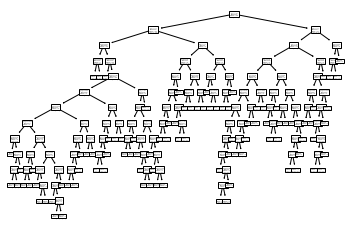

In [16]:
from sklearn import tree

CART_model = tree.DecisionTreeClassifier(random_state=46) #Initiate the classifier
CART_model.fit(X_train, Y_train) # Fit the model

tree.plot_tree(CART_model) # Print the plot

Métricas entrenamiento----> Acierto = 1.00 , Sensibilidad = 1.00, Especificidad = 1.00, ROC_AUC_SCORE = 1.00, MCC = 1.00
Métricas evaluación----> Acierto = 0.74 , Sensibilidad = 0.78, Especificidad = 0.69, ROC_AUC_SCORE = 0.73, MCC = 0.46


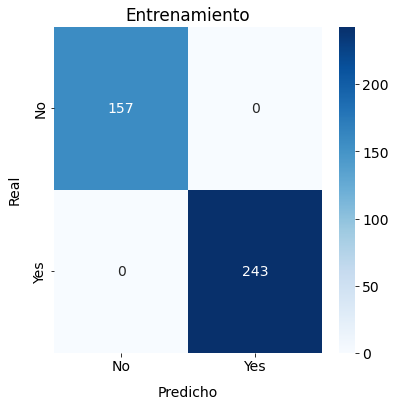

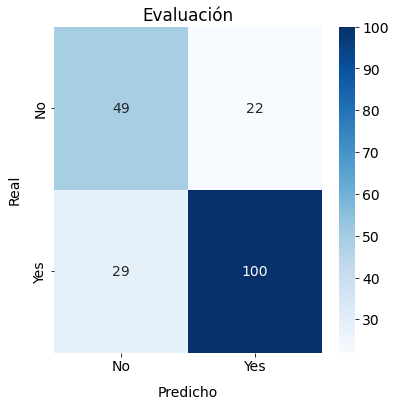

In [17]:
Y_pred_train = CART_model.predict(X_train) # Training set predictions
Y_pred_test = CART_model.predict(X_test) # Test set predictions


metricas_train_lr=reporte(Y_train,Y_pred_train,partition='entrenamiento') # Training set metrics
metricas_test_lr=reporte(Y_test,Y_pred_test,partition='evaluación') # Test set metrics

conf_mat(Y_train,Y_pred_train,partition='Entrenamiento') # Training set confusion matrix
conf_mat(Y_test,Y_pred_test,partition='Evaluación') # Test set confusion matrix

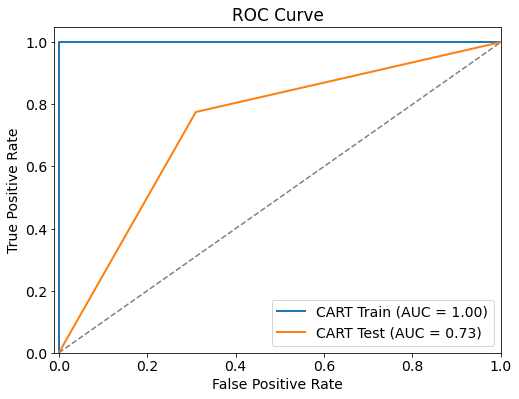

In [18]:
plot_multi_roc_curves(Y_train,Y_test,{'CART':Y_pred_train},{'CART':Y_pred_test}) # ROC curve

CART: hyperparameter optimization

In [21]:
from sklearn.model_selection import GridSearchCV
grid_searches_rf = {'best_params': [], 'best_score': []} # Create the grid

model_cart = tree.DecisionTreeClassifier(random_state=46)

params = {'criterion': ['gini', 'entropy'],
          'min_samples_split': [2,4,6],
          'max_depth': [None, 2,4,6],
          'class_weight': [None, 'balanced']} # Add the hyperparameters

# Grid Search, cross-validation 5-fold
gs = GridSearchCV(model_cart, params, cv=5, verbose=1, scoring=make_scorer(roc_auc_score), refit=False, return_train_score=True)
gs.fit(X_train, Y_train)

grid_searches_rf['best_params'].append(gs.best_params_)
grid_searches_rf['best_score'].append(gs.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [22]:
grid_searches_rf # best parameters

{'best_params': [{'class_weight': None,
   'criterion': 'entropy',
   'max_depth': 4,
   'min_samples_split': 2}],
 'best_score': [0.6845848420013165]}

In [25]:
model_cart_def=tree.DecisionTreeClassifier(**gs.best_params_,random_state=46).fit(X_train,Y_train) # Fit again the tree with the best parameters

Métricas entrenamiento----> Acierto = 0.80 , Sensibilidad = 0.91, Especificidad = 0.62, ROC_AUC_SCORE = 0.77, MCC = 0.57
Métricas evaluación----> Acierto = 0.85 , Sensibilidad = 0.92, Especificidad = 0.72, ROC_AUC_SCORE = 0.82, MCC = 0.67


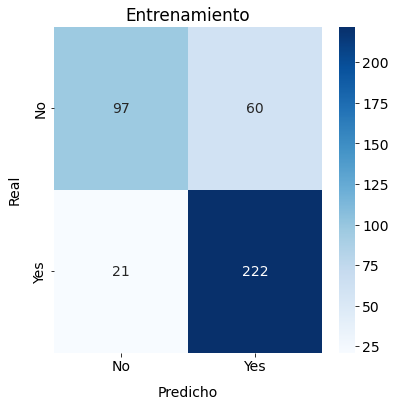

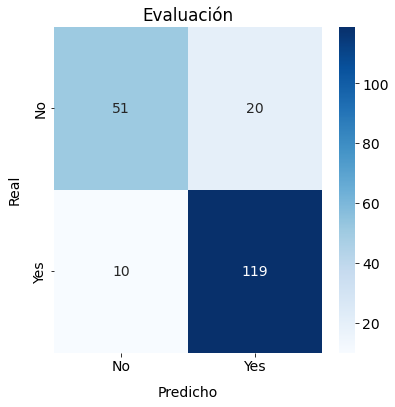

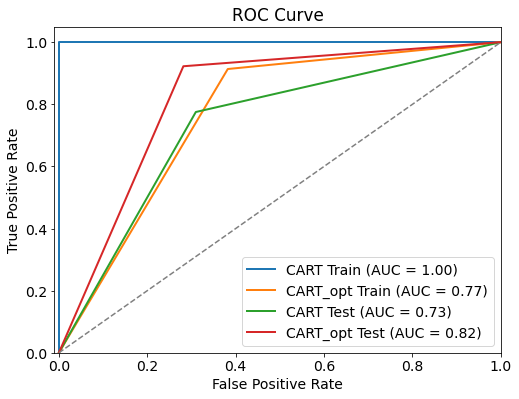

In [24]:
Y_pred_train_def_cart = model_cart_def.predict(X_train) # Predict training set
Y_pred_test_def_cart = model_cart_def.predict(X_test) # Predict test set


metricas_train_lr=reporte(Y_train,Y_pred_train_def_cart,partition='entrenamiento') # Metrics train set
metricas_test_lr=reporte(Y_test,Y_pred_test_def_cart,partition='evaluación') # Metrics test set

conf_mat(Y_train,Y_pred_train_def_cart,partition='Entrenamiento') # Confusion matrix train set
conf_mat(Y_test,Y_pred_test_def_cart,partition='Evaluación') # confusion matrix test set
plot_multi_roc_curves(Y_train,Y_test,{'CART':Y_pred_train,'CART_opt':Y_pred_train_def_cart},{'CART':Y_pred_test,'CART_opt':Y_pred_test_def_cart}) #roc curves

4. Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(random_state=46) # activate the RF model by default
RF_model.fit(X_train, Y_train)

RandomForestClassifier(random_state=46)

Métricas entrenamiento----> Acierto = 1.00 , Sensibilidad = 1.00, Especificidad = 1.00, ROC_AUC_SCORE = 1.00, MCC = 1.00
Métricas evaluación----> Acierto = 0.85 , Sensibilidad = 0.91, Especificidad = 0.75, ROC_AUC_SCORE = 0.83, MCC = 0.68


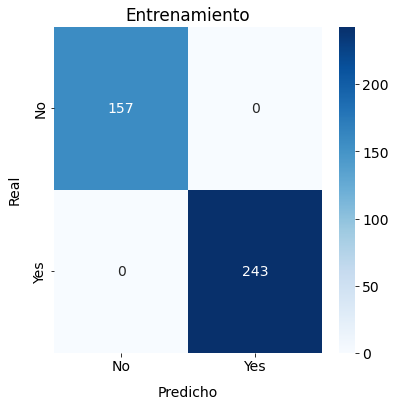

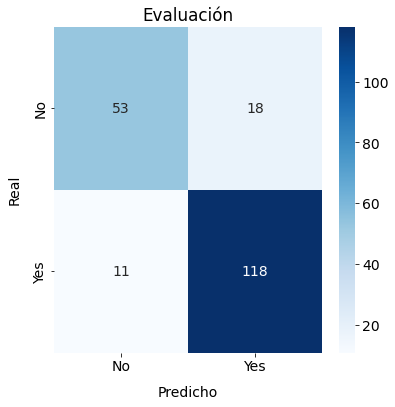

In [28]:
Y_pred_train = RF_model.predict(X_train) # predict train set
Y_pred_test = RF_model.predict(X_test) #predict test set


metricas_train_lr=reporte(Y_train,Y_pred_train,partition='entrenamiento') #metrics train set
metricas_test_lr=reporte(Y_test,Y_pred_test,partition='evaluación') # metrics test set

conf_mat(Y_train,Y_pred_train,partition='Entrenamiento') #confusion matrix train set
conf_mat(Y_test,Y_pred_test,partition='Evaluación') # confusion matrix test set

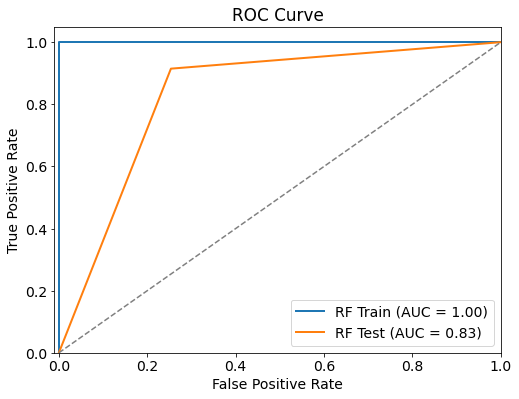

In [29]:
plot_multi_roc_curves(Y_train,Y_test,{'RF':Y_pred_train},{'RF':Y_pred_test}) #roc curves

Random Forest: Hyperparameter optimization

In [40]:
from sklearn.model_selection import GridSearchCV
grid_searches_rf = {'best_params': [], 'best_score': []} # create the grid

model_rf = RandomForestClassifier(random_state=46) #activate the model

params = {'n_estimators': [50,100,200, 300, 500],
          'criterion': ['gini', 'entropy'],
          'min_samples_split': [2,4, 6],
          'max_depth': [None, 2,6],
          'oob_score':[False, True]} # parameters grid

#grid serach
gs = GridSearchCV(model_rf, params, cv=5, verbose=1, scoring=make_scorer(roc_auc_score), refit=False, return_train_score=True)
gs.fit(X_train, Y_train)

grid_searches_rf['best_params'].append(gs.best_params_)
grid_searches_rf['best_score'].append(gs.best_score_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [41]:
grid_searches_rf #best parameters

{'best_params': [{'criterion': 'entropy',
   'max_depth': None,
   'min_samples_split': 2,
   'n_estimators': 50,
   'oob_score': False}],
 'best_score': [0.7456804092604783]}

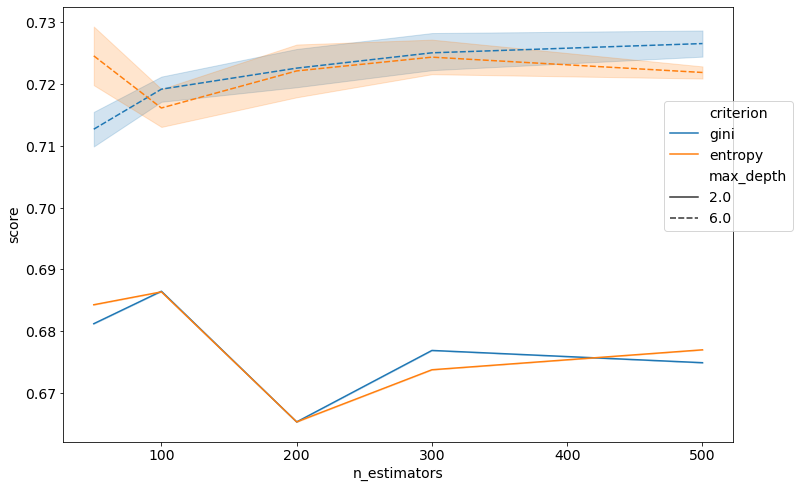

In [42]:
forest_cv_df = pd.DataFrame(gs.cv_results_['params']) 
forest_cv_df['score'] = gs.cv_results_['mean_test_score']
plt.figure(figsize=(12,8))
sns.lineplot(data=forest_cv_df, x='n_estimators', y='score', hue='criterion',style='max_depth')
plt.legend(bbox_to_anchor=[1.1, 0.8])
plt.show()

In [43]:
model_rf_def=RandomForestClassifier(**gs.best_params_,random_state=46).fit(X_train,Y_train) #fit again with the optimal parameters

Métricas entrenamiento----> Acierto = 1.00 , Sensibilidad = 1.00, Especificidad = 1.00, ROC_AUC_SCORE = 1.00, MCC = 1.00
Métricas evaluación----> Acierto = 0.83 , Sensibilidad = 0.90, Especificidad = 0.70, ROC_AUC_SCORE = 0.80, MCC = 0.62


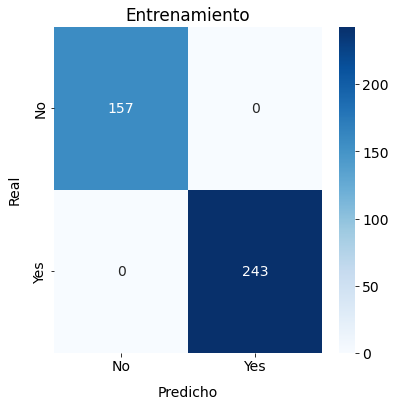

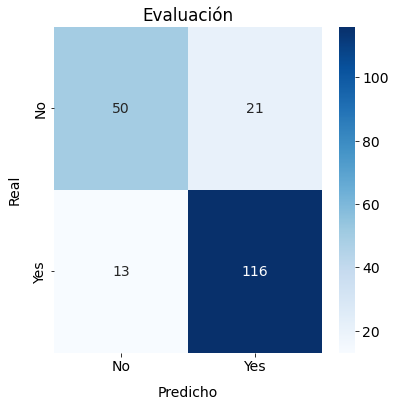

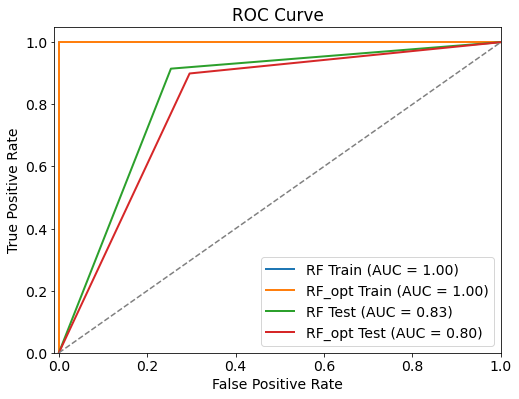

In [44]:
Y_pred_train_def_rf = model_rf_def.predict(X_train) #train set prediction
Y_pred_test_def_rf = model_rf_def.predict(X_test) #test set prediction


metricas_train_lr=reporte(Y_train,Y_pred_train_def_rf,partition='entrenamiento') # metrics train set
metricas_test_lr=reporte(Y_test,Y_pred_test_def_rf,partition='evaluación') #metrics test set

conf_mat(Y_train,Y_pred_train_def_rf,partition='Entrenamiento') #confusion matrix train set 
conf_mat(Y_test,Y_pred_test_def_rf,partition='Evaluación') # confusion matrix test set
plot_multi_roc_curves(Y_train,Y_test,{'RF':Y_pred_train,'RF_opt':Y_pred_train_def_rf},{'RF':Y_pred_test,'RF_opt':Y_pred_test_def_rf}) #roc curves

XGBOOST

In [ ]:
import xgboost as xgb

# Crear el modelo con hiperparámetros ajustados
modelo = xgb.XGBClassifier(
    n_estimators=2000,  # Número de árboles (default: 100)
    max_depth=10,       # Profundidad máxima de los árboles (default: 6)
    learning_rate=0.9, # Tasa de aprendizaje (default: 0.3)
    subsample=0.8,     # Muestra del dataset usada en cada árbol (default: 1)
    colsample_bytree=0.8,  # Fracción de features usadas en cada árbol
    gamma=0.1,         # Reducción mínima de la pérdida para hacer un split
    use_label_encoder=False,
    eval_metric="logloss"
)

# Entrenar el modelo
modelo.fit(X_train, Y_train)


C:\Users\gaspa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:52:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.9, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Precisión del modelo: 0.8100
[[ 56  15]
 [ 23 106]]


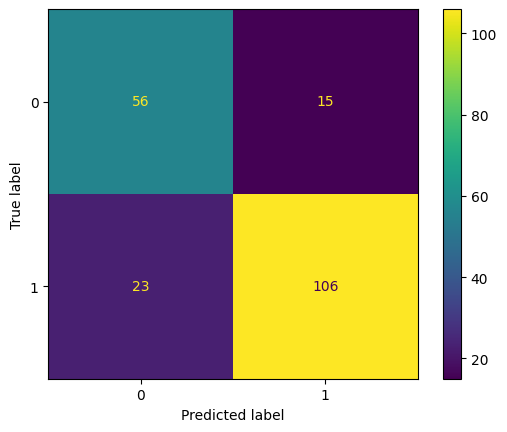

In [ ]:
from sklearn.metrics import accuracy_score

Y_pred = modelo.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print(cm)

disp.plot()

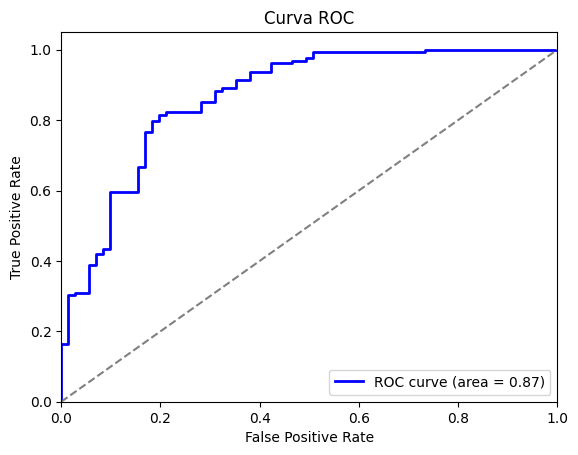

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Y_prob = modelo.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(Y_test, Y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


BAYESIAN TREE

https://althir.medium.com/a-quick-look-at-bayesian-decision-trees-for-classification-4eb696cede60

In [ ]:
from bayesian_decision_tree.classification import HyperplaneClassificationTree
from bayesian_decision_tree.hyperplane_optimization import SimulatedAnnealingOptimizer
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

print("Tipo de Y_train:", type(Y_train))
print("Shape de Y_train:", Y_train.shape)
print("Valores únicos en Y_train:", np.unique(Y_train))


# Convertir Y_train a un array NumPy con el tipo correcto
Y_train = np.array(Y_train, dtype=np.int64)
Y_test = np.array(Y_test, dtype=np.int64)

print("Valores únicos en Y_train:", np.unique(Y_train))

# Initialize optimizer
optimizer = SimulatedAnnealingOptimizer(
    n_scan=10,        # Número de exploraciones
    n_keep=5,         # Número de mejores soluciones que se guardan
    spread_factor=0.5, # Factor de dispersión
    seed=42           # Semilla para reproducibilidad
)

# Initialize and train the model
model_bayesian = HyperplaneClassificationTree(optimizer=optimizer, prior=[0.5, 0.5])
model_bayesian.fit(X_train, Y_train)

# Predict and evaluate
Y_pred_bayes = model_bayesian.predict(X_test)
accuracy_bayes = accuracy_score(Y_test, Y_pred_bayes)
print(f"Accuracy: {accuracy_bayes:.2f}")


Tipo de Y_train: <class 'numpy.ndarray'>
Shape de Y_train: (400,)
Valores únicos en Y_train: [0 1]
Valores únicos en Y_train: [0 1]
Accuracy: 0.77


[[ 49  22]
 [ 24 105]]


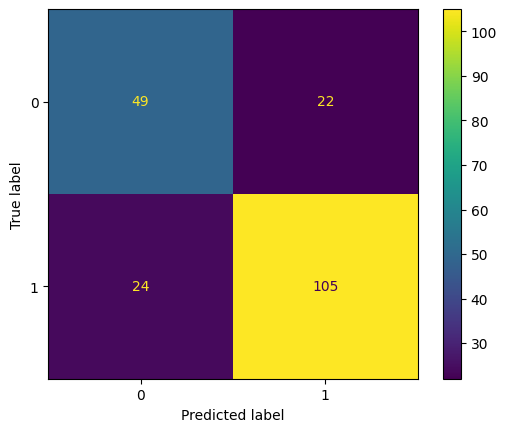

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_bayes = confusion_matrix(Y_test, Y_pred_bayes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_bayes)
print(cm_bayes)

disp.plot()

In [ ]:
from sklearn.metrics import classification_report

TN, FP, FN, TP = cm_bayes.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)  
specificity = TN / (TN + FP)
precision = TP / (TP + FP)


print("Matriz de confusión:\n", cm_bayes)
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")

print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_bayes, digits=4))

Matriz de confusión:
 [[ 49  22]
 [ 24 105]]
Accuracy: 0.7700
Sensitivity (Recall): 0.8140
Specificity: 0.6901
Precision: 0.8268
F1 Score: 0.8203

Classification Report:
              precision    recall  f1-score   support

           0     0.6712    0.6901    0.6806        71
           1     0.8268    0.8140    0.8203       129

    accuracy                         0.7700       200
   macro avg     0.7490    0.7520    0.7504       200
weighted avg     0.7716    0.7700    0.7707       200



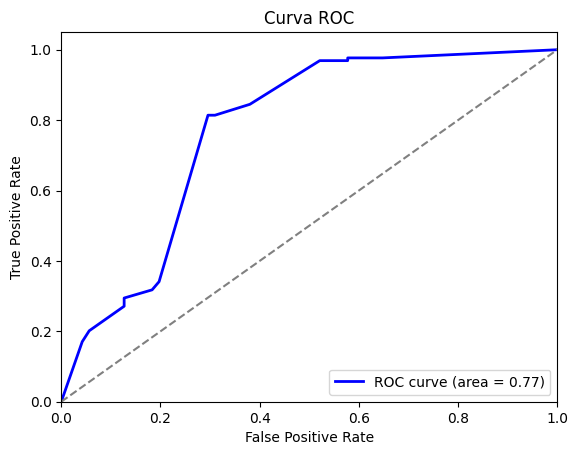

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Y_prob = model_bayesian.predict_proba(X_test)[:, 1]


fpr, tpr, _ = roc_curve(Y_test, Y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

7. MODEL COMPARISON

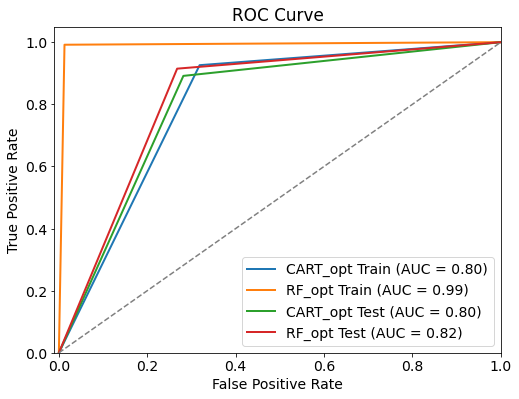

In [ ]:
plot_multi_roc_curves(Y_train,Y_test,{'CART_opt':Y_pred_train_def_cart,'RF_opt':Y_pred_train_def_rf},{'CART_opt':Y_pred_test_def_cart,'RF_opt':Y_pred_test_def_rf}) #roc curves